In [1]:
import os
import os.path as osp

import sys
sys.path.append("..")

from src.circle_detection.hough_circle_detection import *
from src.utility import *
import matplotlib.pyplot as plt
import json
import random
import pandas as pd
import seaborn as sn

%matplotlib inline

In [2]:
path_ds = "../datasets/"
path_ds_test = osp.join(path_ds, "droplets", "test", "original")

In [3]:
path_images = [osp.join(path_ds_test, x) for x in os.listdir(path_ds_test)]

# Baseline Classifier

In [4]:
# idx = 26
idx = 20
image = cv2.imread(path_images[idx])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

list_circles = hough_circle_detection_simple(gray)

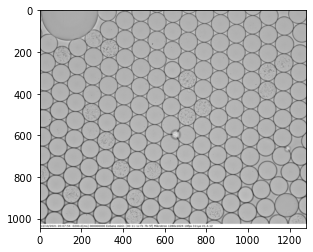

In [5]:
plt.imshow(image, cmap="gray")

## Histogram of sample droplets

### Empty Droplet

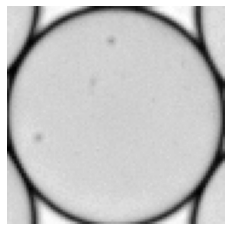

In [6]:
idx_circle = 3
circle = list_circles[0, idx_circle]

x_1 = int(circle[0]) - int(1 * circle[2])
y_1 = int(circle[1]) - int(1 * circle[2])
x_2 = int(circle[0]) + int(1 * circle[2])
y_2 = int(circle[1]) + int(1 * circle[2])

droplet_image = gray[y_1:y_2, x_1:x_2]
plt.axis("off")
plt.imshow(droplet_image, cmap="gray")

In [7]:
image_mask = create_circular_mask(droplet_image.shape).astype("uint8") * 255

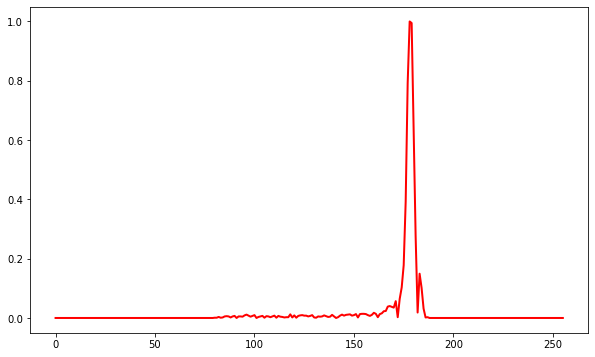

In [8]:
histogram = cv2.calcHist([droplet_image], channels=[0], mask=image_mask, histSize=[256], ranges=[0, 256])
hist_normed = cv2.normalize(histogram, histogram, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
plt.figure(figsize=(10, 6))
plt.plot(hist_normed, "r", linewidth=2)
plt.show()

In [9]:
hist_normed.sum()

5.553712

### Bacteria Droplet

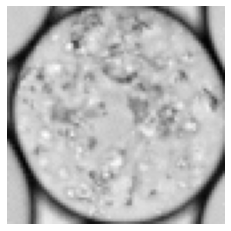

In [10]:
idx_circle = 100
circle = list_circles[0, idx_circle]

x_1 = int(circle[0]) - int(1 * circle[2])
y_1 = int(circle[1]) - int(1 * circle[2])
x_2 = int(circle[0]) + int(1 * circle[2])
y_2 = int(circle[1]) + int(1 * circle[2])

droplet_image = gray[y_1:y_2, x_1:x_2]
plt.axis("off")
plt.imshow(droplet_image, cmap="gray")

In [11]:
image_mask = create_circular_mask(droplet_image.shape).astype("uint8") * 255

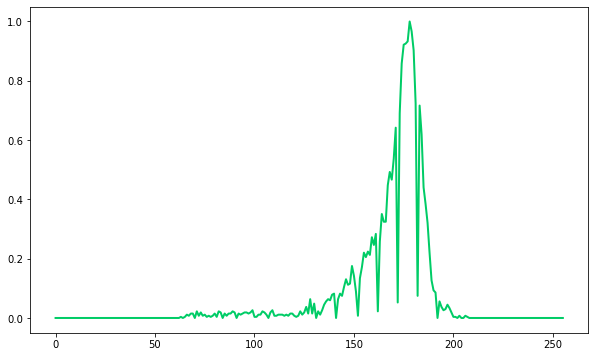

In [12]:
histogram = cv2.calcHist([droplet_image], channels=[0], mask=image_mask, histSize=[256], ranges=[0, 256])
hist_normed = cv2.normalize(histogram, histogram, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
plt.figure(figsize=(10, 6))
plt.plot(hist_normed, color=(0, 204/255, 102/255), linewidth=2)
plt.show()

In [13]:
hist_normed.sum()

19.623133

## The classifier

In [14]:
# Classifier
thres = 16
list_cls = []
for circle in list_circles[0]:
    _, hist_sum = calculate_hist_sum(gray, circle)
    list_cls.append(1 if hist_sum > thres else 0)

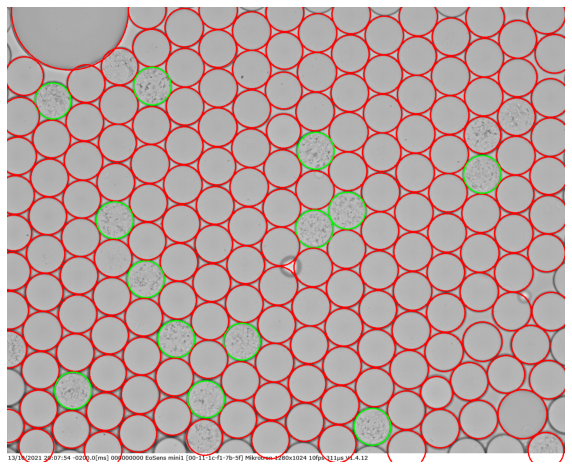

In [16]:
image_copy = image.copy()
for circle, cls in zip(list_circles[0], list_cls):
    circle = circle.astype(int)
    cv2.circle(image_copy, (circle[0], circle[1]), circle[2], (255 * (cls == 0), 255 * (cls == 1), 0), 2)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(image_copy)
    

# How good is baseline classifier ?

In [18]:
# load the labels

with open("../datasets/droplets/label-data-min.json") as infile:
    label_json = json.load(infile)

In [19]:
# load the images

images = []
labels = []
for image in label_json:
    
    image_filename = image["image"][24:]
    # print(image_filename)
    img = cv2.imread(f"../datasets/droplets/label-data/{image_filename}")
    
    if img is None:
        print(image_filename)
    img = cv2.resize(img, (224,224))
    
    img = np.array(img, dtype=np.float32)

    # Normalise the images
    img /= 255
    
    label = image["choice"]
    
    if label == "Not_Droplet":
        label = 2
    if label == "Empty":
        label = 0
    if label == "Bacteria":
        label = 1

    
    images.append(img)
    
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [20]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

In [21]:
# remove not a droplets from the images, because histogram classificator cannot classify them

from sklearn.model_selection import train_test_split
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.30, random_state=seed_value)

not_a_droplet_mask_train = labels_train!=2
images_train = images_train[not_a_droplet_mask_train]
labels_train = labels_train[not_a_droplet_mask_train]

not_a_droplet_mask_test = labels_test!=2
images_test = images_test[not_a_droplet_mask_test]
labels_test = labels_test[not_a_droplet_mask_test]

In [22]:
def predict_hist(images, threshold):
    predicition = [1 if calculate_hist_sum((image*255), (112,112,112))[1] > threshold else 0 for image in images]
    return predicition

In [23]:
# "training the threshold parameter"
from sklearn.metrics import f1_score

threshold_train_max = 0
threshold_train_max_value = 0
for threshold in np.linspace(0, 20, 200):
    y_pred = predict_hist(images_train, threshold)
    f1 = f1_score(labels_train, y_pred)
    
    if(f1 > threshold_train_max):
        threshold_train_max_value = threshold
        threshold_train_max = f1

In [24]:
print(f"Optimal parameters: f1 {threshold_train_max}, threshold {threshold_train_max_value}")

Optimal parameters: f1 0.9611388995767602, threshold 4.92462311557789


In [25]:
# get prediction on the test set with this threshold

y_pred = predict_hist(images_test, threshold_train_max_value)

<AxesSubplot:>

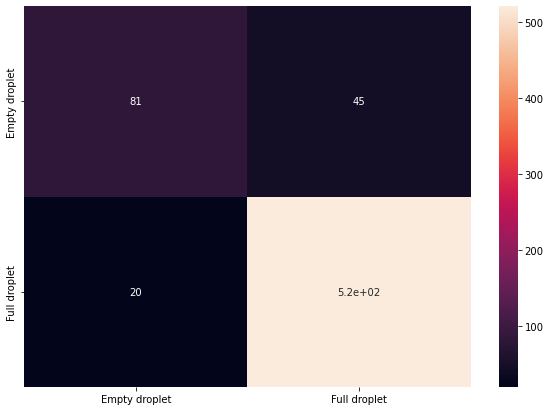

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

df_cm = pd.DataFrame(confusion_matrix(labels_test, y_pred), index = ["Empty droplet", "Full droplet"],
                                                          columns = ["Empty droplet", "Full droplet"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [27]:
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       126
           1       0.92      0.96      0.94       541

    accuracy                           0.90       667
   macro avg       0.86      0.80      0.83       667
weighted avg       0.90      0.90      0.90       667

